# GC% content reducer, randomised

In [10]:
"""
Module: GC% content reducer, randomised
Author: Fabio Rodrigues
Version: 13.0
Description: This module provides a tool that reduces the GC% content of a DNA 
sequence, by randomly replacing the original codons with new one, that have
lower GC%.
"""

__author__ = "Fabio Rodrigues"
__version__ = "13.0"

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import random
from tqdm.auto import tqdm

In [14]:
# # The line below changes the graph size shown on screen
plt.rcParams['figure.dpi'] = 130

sns.set_style("darkgrid", {"grid.color": "w",
                           "grid.linestyle": "-",
                           'axes.edgecolor': 'k',
                           'xtick.bottom' : True,
                           'ytick.left':True})

# Version 13 - randomised codons

2025/04/29

By Fabio Rodrigues

In [24]:
def GC_reducer_tool_rd(ID,
                       DNA_seq,
                       save_results_to,
                       name_file,
                       save_it):

    """
    Optimizes a DNA sequence to reduce its GC content while preserving the protein sequence.

    This function takes a DNA sequence as input, translates it into a protein sequence
    using a reference codon table, and then reverse translates the protein sequence
    back into a DNA sequence using a randomized codon selection strategy biased
    towards lower GC content. It then calculates and reports the initial and final
    GC percentages, the percentage reduction in GC content, and verifies if the
    protein sequence is conserved after the optimization. The results are printed
    to the console and optionally saved to a CSV file and visualized as bar and
    line plots.

    Args:
        ID (str): A unique identifier for the DNA sequence. This will be used
            in the output file names and plot titles.
        DNA_seq (str): The DNA sequence to be optimized. It is crucial that
            this sequence is provided in the 5' to 3' orientation.
        save_results_to (str): The directory path where the output CSV file
            and PNG image(s) will be saved if `save_it` is 'y' or 'Y'.
        name_file (str): The base name for the output files (CSV and PNG).
            The function will append suffixes like '_data', '_bar', and '_GC_av'
            to this base name.
        save_it (str): A string indicating whether to save the results to a file.
            Use 'y' or 'Y' to save, and any other value (e.g., 'n' or 'N') to skip saving.

    Returns:
        pandas.DataFrame: A transposed DataFrame containing the sequence ID,
            the GC%-reduced DNA sequence, the translated protein sequence,
            the initial and final GC percentages, the percentage reduction
            in GC content, and a boolean indicating if the protein sequence
            was conserved. This DataFrame is also saved to a CSV file if `save_it`
            is 'y' or 'Y'.

    Outputs (if save_it is 'y' or 'Y'):
        - A CSV file (named '{name_file}_data.csv') containing the transposed
          output data.
        - A bar plot (named '{name_file}_bar.png') showing the initial and
          final GC percentages.
        - A line plot (named '{name_file}_GC_av.png') showing the average GC
          content over 50-base pair windows for both the original and
          optimized DNA sequences.

    Example:
        >>> ID = 'MySequence'
        >>> DNA_seq = 'ATGCGTAGCTAGCTAGCTAGCTAGCTAGCTAGC'
        >>> save_results_to = '/path/to/save/results/'
        >>> name_file = 'optimized_sequence'
        >>> save_it = 'y'
        >>> result_df = GC_reducer_tool_rd(ID, DNA_seq, save_results_to, name_file, save_it)
        
        Sequence ID:  MySequence
         
        GC%-reduced DNA sequence
        ATGCGTAGCTAGCTAGCTAGCTAGCTAGCTAGC
         
        Translated protein
        MRSSSAS
         
        Initial   GC%: 40.7
        Final     GC%: 30.7
        GC content reduced by  10.0 %
         
        Protein sequence conserved before and after optimization:  True
        Files saved successfully      
    """

        """Add the sequence name - It will be added to the graphs title"""
    ID = ID
    
    """DNA sequence to be optimized.
    Make sure it is in 5' -> 3' orientation!"""
    DNA_seq = DNA_seq    
    
################################################################################
    """Standard codon table
    Here you can add the codon table of preference"""
    
    codon_table = {
        'TTT': 'F', 'TTC': 'F', 'TTA': 'L', 'TTG': 'L', 'CTT': 'L',
        'CTC': 'L', 'CTA': 'L', 'CTG': 'L', 'ATT': 'I', 'ATC': 'I',
        'ATA': 'I', 'ATG': 'M', 'GTT': 'V', 'GTC': 'V', 'GTA': 'V',
        'GTG': 'V', 'TCT': 'S', 'TCC': 'S', 'TCA': 'S', 'TCG': 'S',
        'CCT': 'P', 'CCC': 'P', 'CCA': 'P', 'CCG': 'P', 'ACT': 'T',
        'ACC': 'T', 'ACA': 'T', 'ACG': 'T', 'GCT': 'A', 'GCC': 'A',
        'GCA': 'A', 'GCG': 'A', 'TAT': 'Y', 'TAC': 'Y', 'TAA': '*',
        'TAG': '*', 'CAT': 'H', 'CAC': 'H', 'CAA': 'Q', 'CAG': 'Q',
        'AAT': 'N', 'AAC': 'N', 'AAA': 'K', 'AAG': 'K', 'GAT': 'D',
        'GAC': 'D', 'GAA': 'E', 'GAG': 'E', 'TGT': 'C', 'TGC': 'C',
        'TGA': '*', 'TGG': 'W', 'CGT': 'R', 'CGC': 'R', 'CGA': 'R',
        'CGG': 'R', 'AGT': 'S', 'AGC': 'S', 'AGA': 'R', 'AGG': 'R',
        'GGT': 'G', 'GGC': 'G', 'GGA': 'G', 'GGG': 'G'}
################################################################################
    

    """This reverse codon table is used to generate a 
    new table with randomised codons."""

    codon_table_rev = {}
    for codon, amino_acid in codon_table.items():
        codon_table_rev.setdefault(amino_acid, []).append(codon)
    
    ## This is how the codon_table_rev should look like
    # codon_table_rev = {
    # 'F': ['TTT', 'TTC'],
    # 'L': ['TTA', 'TTG', 'CTT', 'CTC', 'CTA', 'CTG'],
    # 'I': ['ATT', 'ATC', 'ATA'],
    # 'M': ['ATG'],
    # 'V': ['GTT', 'GTC', 'GTA', 'GTG'],
    # 'S': ['TCT', 'TCC', 'TCA', 'TCG', 'AGT', 'AGC'],
    # 'P': ['CCT', 'CCC', 'CCA', 'CCG'],
    # 'T': ['ACT', 'ACC', 'ACA', 'ACG'],
    # 'A': ['GCT', 'GCC', 'GCA', 'GCG'],
    # 'Y': ['TAT', 'TAC'],
    # '*': ['TAA', 'TAG', 'TGA'],
    # 'H': ['CAT', 'CAC'],
    # 'Q': ['CAA', 'CAG'],
    # 'N': ['AAT', 'AAC'],
    # 'K': ['AAA', 'AAG'],
    # 'D': ['GAT', 'GAC'],
    # 'E': ['GAA', 'GAG'],
    # 'C': ['TGT', 'TGC'],
    # 'W': ['TGG'],
    # 'R': ['CGT', 'CGC', 'CGA', 'CGG', 'AGA', 'AGG'],
    # 'G': ['GGT', 'GGC', 'GGA', 'GGG']}

################################################################################
################################################################################
    """This generates a new reverse codon table,
    with randomized codon selection"""
    codon_table_reduced = {}

    for key, values in codon_table_rev.items():
        random_value = random.choice(values)
        codon_table_reduced[key] = random_value
    

################################################################################
################################################################################
    """Translates the original DNA into a protein"""
    DNA_seq_ = DNA_seq.upper()
    def translate_DNA_to_protein(DNA_seq_, codon_table):
        protein_seq = ''
        for i in tqdm(range(0, len(DNA_seq_), 3),
                     desc="Translating DNA"):
            codon = DNA_seq_[i:i+3]
            amino_acid = codon_table.get(codon, '')  # '' = an unknown aa
            protein_seq += amino_acid
        return protein_seq
################################################################################

################################################################################
    """Reverse translates the protein into DNA, using S coelicolor
    reduced GC% codon table"""
    def reduced_GC(input_DNA, codon_table_reduced):
        translation_table = str.maketrans(codon_table_reduced)
        replaced_string = input_DNA.translate(translation_table)
        return replaced_string
################################################################################
    
################################################################################
    """Generates the protein and DNA sequences defined above"""
    protein_seq = translate_DNA_to_protein(DNA_seq_, codon_table)
    optimized_DNA = reduced_GC(protein_seq, codon_table_reduced)
                                                                                   
    """Calculates the GC% before and after optimization, and the % variation"""
    GC_initial = (round((DNA_seq_.count('C')+DNA_seq_.count('G'))/
                        len(DNA_seq_)*100,1))
    GC_final = (round((optimized_DNA.count('C')+optimized_DNA.count('G'))/
                 len(optimized_DNA)*100,1))
    delta_GC = round(100-(GC_final*100)/GC_initial,1)
                                                                                   
    """Translates the optimized, GC% reduced DNA sequence 
    into protein sequence"""
    protein_seq_opt = translate_DNA_to_protein(optimized_DNA, codon_table)
################################################################################

################################################################################
    """Quality control: verifies if the protein sequence remains 
    identical before and after the optimization"""
    QC = protein_seq == protein_seq_opt
                                                                                   
    output_data = {
        'Sequence ID: ': [ID],
        'GC%-reduced DNA sequence': [optimized_DNA],
        'Translated protein': [protein_seq],
        'Initial  GC%:': [GC_initial],
        'Final    GC%:': [GC_final],
        'GC content reduced / % ': [delta_GC],
        'Protein sequence conserved before and after optimization: ': [QC]}
                                                                                   
    df_output = pd.DataFrame(output_data)
    df_output_t = df_output.transpose()
################################################################################

################################################################################
    """Saves data as csv"""
    def save_file_out(file_name, save):
                                                                                   
        if save == 'Y' or save == 'y':
            df_output_t.to_csv((save_results_to + file_name + '.csv'))
            print('Files saved successfully')
        else:
            print('No files were saved')
        return df_output_t
################################################################################

################################################################################
    """Prints the results"""
    print('Sequence ID: ',ID)
    print()
    print('GC%-reduced DNA sequence')
    print(optimized_DNA)
    print()
    print('Translated protein')
    print(protein_seq)
    print()
    print('Initial  GC%:',GC_initial)
    print('Final    GC%:',GC_final)
    print('GC content reduced by ',delta_GC, '%')
    print()
    print()
    print('Protein sequence conserved before and after optimization: ', QC)
    print()
################################################################################

################################################################################
    """Generates a bar chart with the calculated GC%"""
    def save_bar_fig(file_name, save):
        labels = ['Initial GC%','Final GC%']
        data = [GC_initial,GC_final]
                                                                                   
        fig, ax = plt.subplots()
        ax.bar(labels,data,
                    color='steelblue',
                    edgecolor='k')
        ax.set_ylabel('GC%')
                                                                                   
        ax.set_title(f"{ID} GC% reduction")
                                                                                   
        ax.text(s=f"{GC_initial} %",
                x=-0.05,
                y=GC_initial+1,
                c='k')
                                                                                   
        ax.text(s=f"{GC_final} %",
                x=0.95,
                y=GC_final+1,
                c='k')
                                                                                   
        ax.set_ylim(0,GC_initial+10)

    #Saves figure as png
        if save == 'Y' or save == 'y':
            plt.savefig(save_results_to +file_name+'.png',
                        dpi = 300,
                        facecolor='w',
                        edgecolor='w',
                        bbox_inches='tight')
    plt.show()
    print()
################################################################################
    
################################################################################
    """Table that gives a score of 1 to G,C and 0 to A,T"""
    score_table = {'C':'1',
                   'G':'1',
                   'A':'0',
                   'T':'0'}
################################################################################
    
###############################################################################
    """Original DNA Block
    ==========================================================================
    This converts the DNA sequence into a score sequence, 
    according to score_table"""
    def GC_score_opt(DNA_seq_, score_table):
        scores = str.maketrans(score_table)
        scores_list = DNA_seq_.translate(scores)
        return scores_list
                                                                               
    """Generates the score list mentioned above"""
    bases_scores = GC_score_opt(DNA_seq_, score_table)
    bases_scores
    SCR = [bases_scores]
                                                                               
    """Extract the string from the list"""
    scr_string = SCR[0]
                                                                               
    """Create a new list with average values of 50-character stretches"""
    avg_list = []
    for i in tqdm(range(0, len(scr_string), 50),
                 desc="Calculating original GC averages"):
        chunk = scr_string[i:i+50]
        average = (sum(int(char) for char in chunk) / len(chunk)*100)
        avg_list.append(average)
################################################################################

################################################################################
    """Optimized DNA Block
    ==========================================================================
     This converts the DNA sequence into a score sequence,
     according to score_table"""
    def GC_score_original(optimized_DNA, score_table):
        scores = str.maketrans(score_table)
        scores_list = optimized_DNA.translate(scores)
        return scores_list
                                                                               
    """Generates the score list mentioned above"""
    bases_scores_opt = GC_score_original(optimized_DNA, score_table)
    bases_scores_opt
    SCR_opt = [bases_scores_opt]
                                                                               
    """Extract the string from the list"""
    scr_string_opt = SCR_opt[0]
                                                                               
    """Create a new list with average values of 50-character stretches"""
    avg_list_opt = []
    for i in tqdm(range(0, len(scr_string_opt), 50),
                 desc="Calculating optimized GC averages"):
        chunk_opt = scr_string_opt[i:i+50]
        average_opt = (sum(int(char) for
                           char in chunk_opt) / len(chunk_opt)*100)
        avg_list_opt.append(average_opt)
                                                                               
    """This generates the x-axis values for the plot"""
    lengths = [len(item) for item in SCR]
                                                                               
    step = 50
    lower_limit = step
    upper_limit = lengths[0]
                                                                               
    rangex = []
    value = lower_limit
                                                                               
    while value <= upper_limit:
        rangex.append(value)
        value += step
                                                                               
    if rangex[-1] != upper_limit:
        rangex.append(upper_limit)
################################################################################

################################################################################
    """This makes a graph showing the scores for each 50-character stretch"""
    def save_GC_av_fig(file_name, save):
        fig, ax = plt.subplots()
                                                                               
        ax.plot(rangex,avg_list, label='Original DNA')
        ax.plot(rangex,avg_list_opt,label='Optimized DNA')
        ax.set_xlabel('Base pairs')
        ax.set_ylabel('Average GC% (50 bases segments)')
        ax.set_xticks(range(0,lengths[0]+1,50))
        ax.set_title(f"{ID} average GC% content")
        ax.legend()
        ax.set_ylim(0,109)
        ax.set_xscale('linear')
                                                                               
        #Saves figure as png
        if save == 'Y' or save == 'y':
            plt.savefig(save_results_to +file_name+'.png',
                        dpi = 300,
                        facecolor='w',
                        edgecolor='w',
                        bbox_inches='tight')
                                                                               
    plt.show()
################################################################################

    """Add path to where the files should be saved"""
    save_results_to = save_results_to
    """Add file name"""
    name_file = name_file
    """Save file? Type 'y' or 'n'"""
    save_it = save_it
    
################################################################################
    save_file_out(name_file+'_data',save_it)
    save_bar_fig(name_file+'_bar',save_it)
    save_GC_av_fig(name_file+'_GC_av',save_it)
    plt.show()
################################################################################

# """Function block for reference
# Add the sequence name - It will be added to the graphs' title
# ID              = 'Hygromycin'

# Add DNA sequence to be optimized, in 5' -> 3' orientation.
# DNA_seq         = ('atgtcatcagcggtggagtgcaatgtcgcgagatcctggccgcgctgctcgacgggga')

# Add path to where the files should be saved
# save_results_to = (r"'/path/to/save/results/'")

# Add file name
# name_file       = 'Hygro_res_refac'

# Save file? Type 'y' or 'n'
# save_it         = 'n'

# ################################################################################
# GC_reducer_tool(ID,
#                 DNA_seq,
#                 save_results_to,
#                 name_file,
#                 save_it)"""

Translating DNA:   0%|          | 0/342 [00:00<?, ?it/s]

Translating DNA:   0%|          | 0/342 [00:00<?, ?it/s]

Sequence ID:  Hygromycin

GC%-reduced DNA sequence
ATGAGCAGCGCAGTGGAGTGTAATGTGGTGACTCAGGAGAGCCTACTACTACTAGACAGGATTGACAGCGACGACAGCTATGCAAGCCTAAGGAATGACCAGGAGTTCTGGGAGCCGCTAGCAAGGAGGGCACTAGAGGAGCTAGGCCTACCGGTGCCGCCGGTGCTAAGGGTGCCGGGCGAGAGCACTAATCCGGTGCTAGTGGGCGAGCCGGGCCCGGTGATTAAGCTATTCGGCGAGCATTGGTGTGGCCCGGAGAGCCTAGCAAGCGAGAGCGAGGCATATGCAGTGCTAGCAGACGCACCGGTGCCGGTGCCGAGGCTACTAGGCAGGGGCGAGCTAAGGCCGGGCACTGGCGCATGGCCGTGGCCGTATCTAGTGATGAGCAGGATGACTGGCACTACTTGGAGGAGCGCAATGGACGGCACTACTGACAGGAATGCACTACTAGCACTAGCAAGGGAGCTAGGCAGGGTGCTAGGCAGGCTACATAGGGTGCCGCTAACTGGCAATACTGTGCTAACTCCGCATAGCGAGGTGTTCCCGGAGCTACTAAGGGAGAGGAGGGCAGCAACTGTGGAGGACCATAGGGGCTGGGGCTATCTAAGCCCGAGGCTACTAGACAGGCTAGAGGACTGGCTACCGGACGTGGACACTCTACTAGCAGGCAGGGAGCCGAGGTTCGTGCATGGCGACCTACATGGCACTAATATTTTCGTGGACCTAGCAGCAACTGAGGTGACTGGCATTGTGGACTTCACTGACGTGTATGCAGGCGACAGCAGGTATAGCCTAGTGCAGCTACATCTAAATGCATTCAGGGGCGACAGGGAGATTCTAGCAGCACTACTAGACGGCGCACAGTGGAAGAGGACTGAGGACTTCGCAAGGGAGCTACTAGCATTCACTTTCCTACATGACTTCGAGGTGTTCGAGGAGACTCCGCTAG

Calculating original GC averages:   0%|          | 0/21 [00:00<?, ?it/s]

Calculating optimized GC averages:   0%|          | 0/21 [00:00<?, ?it/s]

No files were saved


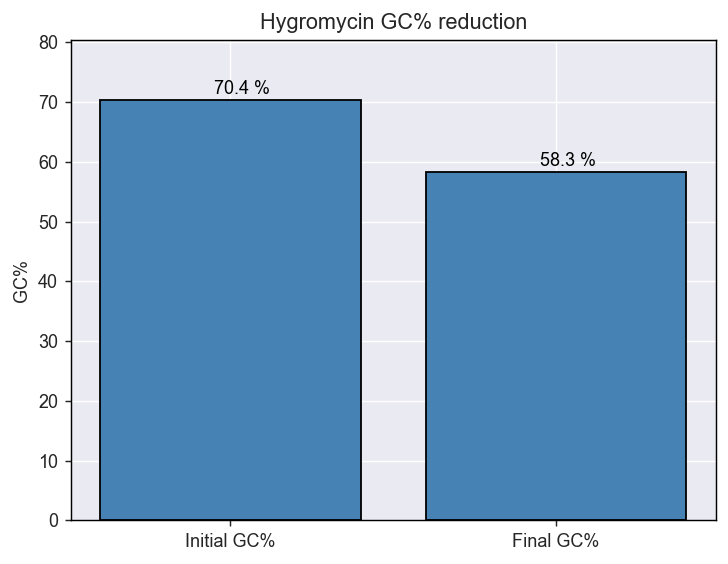

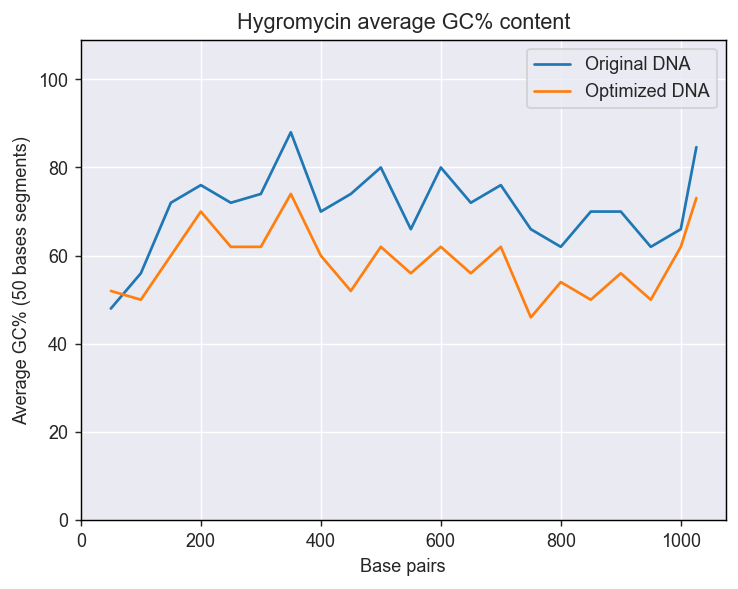

In [21]:
# Add the sequence name - It will be added to the graphs' title

ID              = 'Hygromycin'

# Add DNA sequence to be optimized, in 5' -> 3' orientation.
DNA_seq         = ('atgtcatcagcggtggagtgcaatgtcgtgacacaagaatccctgttacttctcgaccgtattgattcggatgattcctacgcgagcctgcggaacgaccaggaattctgggagccgctggcccgccgagccctggaggagctcgggctgccggtgccgccggtgctgcgggtgcccggcgagagcaccaaccccgtactggtcggcgagcccggcccggtgatcaagctgttcggcgagcactggtgcggtccggagagcctcgcgtcggagtcggaggcgtacgcggtcctggcggacgccccggtgccggtgccccgcctcctcggccgcggcgagctgcggcccggcaccggagcctggccgtggccctacctggtgatgagccggatgaccggcaccacctggcggtccgcgatggacggcacgaccgaccggaacgcgctgctcgccctggcccgcgaactcggccgggtgctcggccggctgcacagggtgccgctgaccgggaacaccgtgctcaccccccattccgaggtcttcccggaactgctgcgggaacgccgcgcggcgaccgtcgaggaccaccgcgggtggggctacctctcgccccggctgctggaccgcctggaggactggctgccggacgtggacacgctgctggccggccgcgaaccccggttcgtccacggcgacctgcacgggaccaacatcttcgtggacctggccgcgaccgaggtcaccgggatcgtcgacttcaccgacgtctatgcgggagactcccgctacagcctggtgcaactgcatctcaacgccttccggggcgaccgcgagatcctggccgcgctgctcgacggggcgcagtggaagcggaccgaggacttcgcccgcgaactgctcgccttcaccttcctgcacgacttcgaggtgttcgaggagaccccgctggatctctccggcttcaccgatccggaggaactggcgcagttcctctgggggccgccggacaccgcccccggcgcctga')

# Add path to where the files should be saved
save_results_to = (r"/path/to/save/results/")

# Add file name
name_file       = 'Hygro_res_refac'

# Save file? Type 'y' or 'n'
save_it         = 'n'

################################################################################
GC_reducer_tool_rd(ID,
                DNA_seq,
                save_results_to,
                name_file,
                save_it)